In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib
import matplotlib.font_manager as font_manager
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
from slmpy import ModularityOptimzer
import sklearn.cluster as cluster
import umap
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches
import os
import copy
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import gridspec

In [3]:
tretulin_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/data/public_data/GSE75140_hOrg.fetal.master.data.frame.txt',sep='\t')

In [4]:
cell_count = {}
cell_names_per_samp = {}
for cell in tretulin_dat['cell_id']:
    samp_name = "_".join(cell.split("_")[1:])
    if samp_name not in cell_count: 
        cell_names_per_samp[samp_name] = []
        cell_count[samp_name] = 0
    cell_count[samp_name] += 1
    cell_names_per_samp[samp_name].append(cell)

In [5]:
samp_order = ['fetal_12wpc_c1','fetal_12wpc_c2','fetal_13wpc','hOrg33d_c1','hOrg33d_c2',
              'hOrg35d','hOrg37d','hOrg41d','hOrg65d','hOrg_ESC_reg1_53d','hOrg_ESC_reg2_53d',
              'hOrg_iPSC_reg3_58d','hOrg_iPSC_reg4_58d']

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <a list of 10 Text yticklabel objects>)

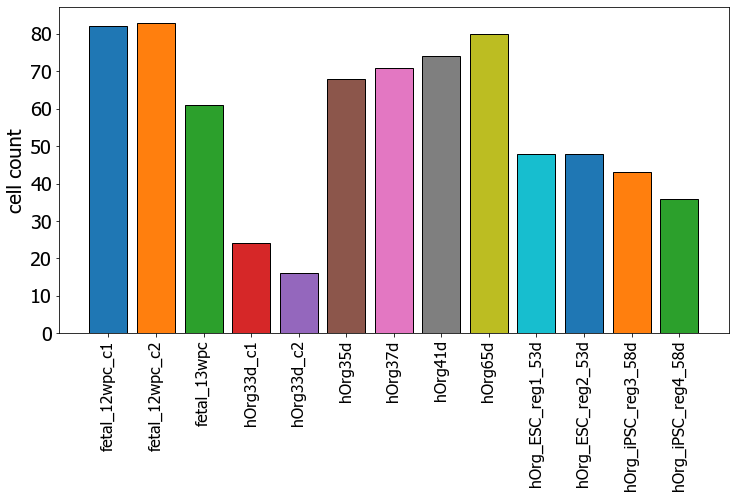

In [6]:
fig = plt.figure(figsize=(12,6))
xticklabs = []
for j,samp in enumerate(samp_order):
    plt.bar(j,cell_count[samp],width=0.8,edgecolor='black')
    xticklabs.append(samp)
plt.xticks(range(j+1),xticklabs,rotation=90,fontsize=16)
plt.ylabel('cell count',fontsize=20)
plt.yticks(fontsize=20)

In [7]:
fetal_df = tretulin_dat[tretulin_dat['cell_id'].str.contains('fetal')]
fetal_df = fetal_df.drop(['species'],axis=1)
fetal_df.index = fetal_df['cell_id']
fetal_df.index.name = 'cell'
fetal_df = fetal_df.drop(['cell_id'],axis=1)
cells = fetal_df.index

In [8]:
## load in data

sc_dat_dir = '/mnt/e/MPIMG/Rotation/elkabetz/scrna/Brain/counts_elk/'
single_cell_data = {}
for fn in os.listdir(sc_dat_dir):
    print(fn)
    df = pd.read_csv(sc_dat_dir+fn,sep=',')
    df = df.set_index(df['Unnamed: 0'])
    df = df.drop('Unnamed: 0',axis=1)
    #mt_genes = [x for x in df.index if 'MT.' in x]
    #df = df.drop(mt_genes,axis=0)
    single_cell_data[fn.split(".")[0]] = df
    
single_cell_data_norm_rpm = {}
single_cell_data_norm_rpm_logged = {}
add_diff = 1.0
for clust in single_cell_data:

    sc_dat = single_cell_data[clust]
    cols = sc_dat
    sc_dat_backup = copy.deepcopy(sc_dat)
    sc_dat = copy.deepcopy(sc_dat_backup)
    
    ## gives you RPM
    sc_dat.loc[-1]  = sc_dat.sum()/10000.
    sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
    sc_dat = sc_dat.drop([-1])
    single_cell_data_norm_rpm[clust] = sc_dat
    single_cell_data_norm_rpm_logged[clust] = np.log(sc_dat+1.)/np.log(2)
    
full_df_rpm_logged = {}
full_df_counts = {}
for clust in single_cell_data_norm_rpm_logged:
    if 'SBNG' in clust:
        if 'SBN' not in full_df_rpm_logged:
            full_df_rpm_logged['SBN'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBN'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBN'] = pd.concat([full_df_rpm_logged['SBN'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBN'] = pd.concat([full_df_counts['SBN'],single_cell_data[clust]],axis=1)
    if 'SBNx' in clust:
        if 'SBNx' not in full_df_rpm_logged:
            full_df_rpm_logged['SBNx'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBNx'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBNx'] = pd.concat([full_df_rpm_logged['SBNx'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBNx'] = pd.concat([full_df_counts['SBNx'],single_cell_data[clust]],axis=1)
    if 'NT' in clust:
        if 'NT' not in full_df_rpm_logged:
            full_df_rpm_logged['NT'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['NT'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['NT'] = pd.concat([full_df_rpm_logged['NT'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['NT'] = pd.concat([full_df_counts['NT'],single_cell_data[clust]],axis=1)
    if 'XG' in clust:
        if 'X' not in full_df_rpm_logged:
            full_df_rpm_logged['X'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['X'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['X'] = pd.concat([full_df_rpm_logged['X'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['X'] = pd.concat([full_df_counts['X'],single_cell_data[clust]],axis=1)
            
for i,tx in enumerate(full_df_counts.keys()):
    tmp_df=copy.deepcopy(full_df_counts[tx])
    tmp_df[-1] = tmp_df.sum(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        merged_counts_df = copy.deepcopy(tmp_df)
    else:
        merged_counts_df = pd.concat([merged_counts_df,tmp_df],axis=1)

merged_counts_df = merged_counts_df.fillna(0)
sc_dat = copy.deepcopy(merged_counts_df)
sc_dat.loc[-1]  = sc_dat.sum()/10000.
sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
sc_dat = sc_dat.drop([-1])
merged_counts_df_rpm_logged = np.log(sc_dat+1.)/np.log(2)

for i,tx in enumerate(full_df_rpm_logged.keys()):
    tmp_df=copy.deepcopy(full_df_rpm_logged[tx])
    tmp_df[-1] = tmp_df.mean(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        avg_logged_rpm_df = copy.deepcopy(tmp_df)
    else:
        avg_logged_rpm_df = pd.concat([avg_logged_rpm_df,tmp_df],axis=1)
avg_logged_rpm_df = avg_logged_rpm_df.fillna(0)

full_df_counts['X'].columns = ['x.'+col for col in full_df_counts['X'].columns]
full_df_counts['NT'].columns = ['nt.'+col for col in full_df_counts['NT'].columns]
full_df_counts['SBN'].columns = ['sbn.'+col for col in full_df_counts['SBN'].columns]
full_df_counts['SBNx'].columns = ['sbnx.'+col for col in full_df_counts['SBNx'].columns]

NTG1.csv
NTG2.csv
NTG3.csv
NTG4.csv
NTG5.csv
NTG6.csv
NTG7.csv
NTG8.csv
NTG9.csv
SBNG1.csv
SBNG10.csv
SBNG11.csv
SBNG2.csv
SBNG3.csv
SBNG4.csv
SBNG5.csv
SBNG6.csv
SBNG7.csv
SBNG8.csv
SBNG9.csv
SBNxG1.csv
SBNxG10.csv
SBNxG2.csv
SBNxG3.csv
SBNxG4.csv
SBNxG5.csv
SBNxG6.csv
SBNxG7.csv
SBNxG8.csv
SBNxG9.csv
XG1.csv
XG2.csv
XG3.csv
XG4.csv
XG5.csv
XG6.csv
XG7.csv
XG8.csv
XG9.csv


/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/metadata.sbnx_sbn_nt.csv',sep=',')
df_sbnx_sbn_clust = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/tsne.sbnx_sbn_nt.csv',sep=',')
df.columns=['cell','tSNE_1','tSNE_2']
df_sbnx_sbn_tsne = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/pca.sbnx_sbn_nt.csv',sep=',')
cols = list(df.columns)
cols[0] = 'cell'
df.columns = cols
df_sbnx_sbn_pca = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.sbnx_sbn_nt.csv',sep=',')
df_markers = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.all.sbnx_sbn_nt.csv',sep=',')
df_markers_all = copy.deepcopy(df)

In [10]:
all_genes = set([])
clust_df_counts = {}
for clust in set(df_sbnx_sbn_clust['res.0.6']):
    cells_in_clust = list(df_sbnx_sbn_clust['Unnamed: 0'][df_sbnx_sbn_clust['res.0.6'] == clust])
    print(clust,len(cells_in_clust))
    for j,tx in enumerate(['SBNx','SBN','NT']):
        cells_in_clust_in_tx = [x for x in cells_in_clust if x.split(".")[0] == tx.lower()]
        if clust not in clust_df_counts:
            if len(cells_in_clust_in_tx) > 0:
                clust_df_counts[clust] = copy.deepcopy(full_df_counts[tx][cells_in_clust_in_tx])
        else:
            if len(cells_in_clust_in_tx) > 0:
                clust_df_counts[clust] = pd.concat([clust_df_counts[clust],full_df_counts[tx][cells_in_clust_in_tx]],axis=1)

for clust in clust_df_counts:
    clust_df_counts[clust] = clust_df_counts[clust].fillna(0)
    all_genes = set(all_genes.union(set(clust_df_counts[clust].index)))

clust_df_log_rpm = {}
for clust in clust_df_counts:
    clust_df_log_rpm[clust] = copy.deepcopy(clust_df_counts[clust])
    tot_sum = clust_df_log_rpm[clust].sum()/10000.
    clust_df_log_rpm[clust] = clust_df_log_rpm[clust].div(tot_sum)
    clust_df_log_rpm[clust] = np.log(clust_df_log_rpm[clust]+1)/np.log(2)

0 1351


/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


1 1221
2 1052
3 1028
4 959
5 951
6 610
7 540
8 407
9 366
10 285
11 208


In [11]:
summed_counts_per_clust = {}
for clust in clust_df_counts:
    summed_counts_per_clust[clust] = clust_df_counts[clust].sum(axis=1)
    tot_sum = summed_counts_per_clust[clust].sum()/10000.
    summed_counts_per_clust[clust] = summed_counts_per_clust[clust].div(tot_sum)
    summed_counts_per_clust[clust] = np.log(summed_counts_per_clust[clust]+1.)/np.log(2)

In [12]:
marker_genes = list(set(df_markers_all[df_markers_all['cluster'].isin([1,5,3,0])]['Unnamed: 0']))
shared_marker_genes = [x for x in marker_genes if x in fetal_df.columns and x in all_genes]
print(len(shared_marker_genes))

648


In [13]:
fetal_df = fetal_df.transpose()

In [14]:
fetal_df['mean'] = fetal_df[cells].mean(axis=1)
fetal_df['std'] = fetal_df[cells].std(axis=1)
fetal_df_zscores = fetal_df[cells].sub(fetal_df['mean'],axis=0).div(fetal_df['std'],axis=0)
print(len(shared_marker_genes))
shared_marker_genes = list(set(shared_marker_genes) - \
    set(fetal_df_zscores[cell].loc[shared_marker_genes][np.isnan(fetal_df_zscores[cells[0]].loc[shared_marker_genes])].index))
print(len(shared_marker_genes))

648
647


In [15]:
for j,clust in enumerate([1,7,5,3,0]):
    if j == 0:
        summed_zscores_per_clust = copy.deepcopy(pd.DataFrame(summed_counts_per_clust[clust]))
    else:
        summed_zscores_per_clust = pd.concat([summed_zscores_per_clust,pd.DataFrame(summed_counts_per_clust[clust])],axis=1)
summed_zscores_per_clust.columns = [1,7,5,3,0]
summed_zscores_per_clust
summed_zscores_per_clust['mean'] = summed_zscores_per_clust[[1,7,5,3,0]].mean(axis=1)
summed_zscores_per_clust['std'] = summed_zscores_per_clust[[1,7,5,3,0]].std(axis=1)
summed_zscores_per_clust[[1,7,5,3,0]] = summed_zscores_per_clust[[1,7,5,3,0]].sub(summed_zscores_per_clust['mean'],axis=0).div(summed_zscores_per_clust['std'],axis=0)

In [16]:
colors=['red','blue','green','yellow','purple']
cell_corr_dict = {}
for cell in cells:
    cell_corr_dict[cell] = {}
    for j,clust in enumerate([1,7,5,3,0]):
        x,y = summed_counts_per_clust[clust].loc[shared_marker_genes],fetal_df[cell].loc[shared_marker_genes]
        cell_corr_dict[cell][clust] = np.corrcoef(x,y)[0][1]

In [17]:
cell_types = {'Cycling Radial Glia':[],'Radial Glia':[],'Intermediate Progenitors':[],'Transitory State':[],'Neurons':[]}
new_new_order = []
for item in sorted(cell_corr_dict.items()):
    if item[1][5]/max([item[1][y] for y in [1,7,3,0]]) > 1:
        cell_types['Transitory State'].append(item[0])
    elif item[1][0]/max([item[1][y] for y in [1,7,5,3]]) > 1:
        cell_types['Neurons'].append(item[0])
    elif item[1][3]/max([item[1][y] for y in [1,7,5,0]]) > 1:
        new_new_order.append(item[0])
        cell_types['Intermediate Progenitors'].append(item[0])
    elif item[1][7]/max([item[1][y] for y in [1,3,5,0]]) > 1:
        new_new_order.append(item[0])
        cell_types['Cycling Radial Glia'].append(item[0])
    else:
        cell_types['Radial Glia'].append(item[0])

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text yticklabel objects>)

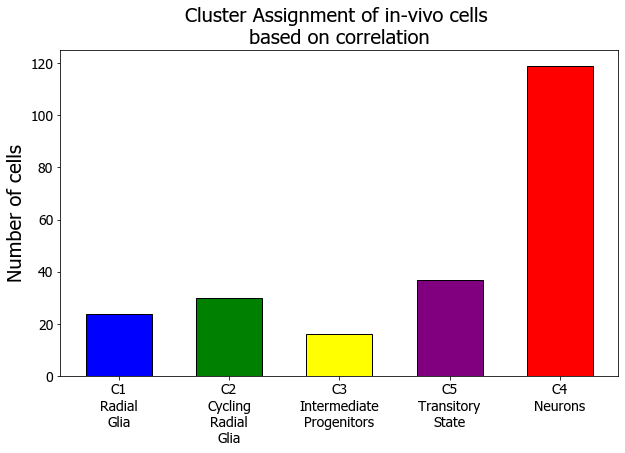

In [18]:
clust_out_map={1:1,7:2,5:5,3:3,0:4}
cort_clusts = [(1,'Radial Glia'),(7,'Cycling Radial Glia'),(3,'Intermediate Progenitors'),(5,'Transitory State'),(0,'Neurons')]
plt.figure(figsize=(10,6))
colors = ['blue','green','yellow','purple','red']
for j,type_ in enumerate(['Radial Glia','Cycling Radial Glia','Intermediate Progenitors','Transitory State','Neurons']):
    plt.bar(j,len(cell_types[type_]),color=colors[j],edgecolor='black',linewidth=1,width=0.6)
plt.title('Cluster Assignment of in-vivo cells \nbased on correlation',fontsize=20)
plt.xticks([0,1,2,3,4],['C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n') \
                                           for x in cort_clusts],fontsize=14)
plt.ylabel('Number of cells',fontsize=20)
plt.yticks(fontsize=14)

In [19]:
clust_map = {}
with open('/mnt/e/MPIMG/Elkabetz/data/public_data/GSE75140_hOrg.cluster_id.txt','r') as clust_fn:
    for i,row in enumerate(clust_fn):
        if i == 0: continue
        spl = row.strip("\n").split("\t")
        cell_name = spl[0].replace('_gw12a','_fetal_12wpc_c1')
        cell_name = cell_name.replace('_gw12b','_fetal_12wpc_c2')
        cell_name = cell_name.replace('_gw13','_fetal_13wpc')
        clust_map[cell_name] = spl[1]
color_map = {'AP1':(32,138,34),'AP2':(144,238,144),'BP1':(0,204,202),'BP2':(141,250,247),'N1':(148,199,242),
             'N2':(71,136,228),'N3':(3,62,193)}
color_map_fixed = {}
for clust in color_map:
    color_map_fixed[clust] = tuple([x/255. for x in color_map[clust]])

In [20]:
sorted_treutlein_clusts = ['AP2','AP1','BP1','BP2','N1','N2','N3']

In [21]:
cort_clusts

[(1, 'Radial Glia'),
 (7, 'Cycling Radial Glia'),
 (3, 'Intermediate Progenitors'),
 (5, 'Transitory State'),
 (0, 'Neurons')]

AP2 {'Cycling Radial Glia': 5, 'Radial Glia': 19, 'Intermediate Progenitors': 0, 'Transitory State': 0, 'Neurons': 0}
19
AP1 {'Cycling Radial Glia': 11, 'Radial Glia': 5, 'Intermediate Progenitors': 0, 'Transitory State': 0, 'Neurons': 0}
11
BP1 {'Cycling Radial Glia': 9, 'Radial Glia': 0, 'Intermediate Progenitors': 1, 'Transitory State': 1, 'Neurons': 0}
9
BP2 {'Cycling Radial Glia': 4, 'Radial Glia': 0, 'Intermediate Progenitors': 4, 'Transitory State': 0, 'Neurons': 0}
4
N1 {'Cycling Radial Glia': 0, 'Radial Glia': 0, 'Intermediate Progenitors': 11, 'Transitory State': 23, 'Neurons': 8}
23
N2 {'Cycling Radial Glia': 0, 'Radial Glia': 0, 'Intermediate Progenitors': 0, 'Transitory State': 8, 'Neurons': 54}
54
N3 {'Cycling Radial Glia': 0, 'Radial Glia': 0, 'Intermediate Progenitors': 0, 'Transitory State': 1, 'Neurons': 56}
56


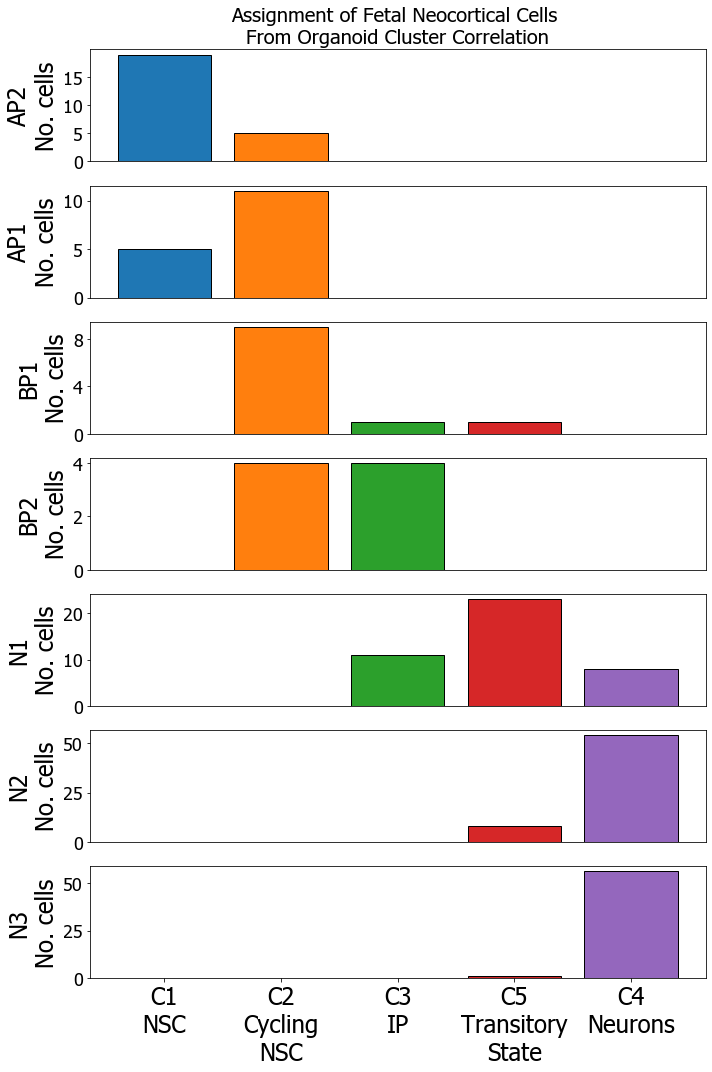

In [24]:
clusts_org = ['Radial Glia','Cycling Radial Glia','Intermediate Progenitors','Transitory State','Neurons']
plt.figure(figsize=(10,15))
colors = sns.color_palette('tab10', n_colors=len(clusts_org))  # a list of RGB tuples

cort_clusts_out = [(1,'NSC'),(7,'Cycling NSC'),(3,'IP'),(5,'Transitory State'),(0,'Neurons')]

for j,clust in enumerate(sorted_treutlein_clusts):
    plt.subplot('71'+str(int(j+1)))
    if j == 0:
        plt.title('Assignment of Fetal Neocortical Cells \nFrom Organoid Cluster Correlation',fontsize=20)
    assign_dict = {}
    for type_ in cell_types: assign_dict[type_] = 0
    for cell in clust_map:
        if clust_map[cell] == clust:
            for type_ in cell_types:
                if cell in cell_types[type_]:
                    assign_dict[type_] += 1
    print(clust,assign_dict)
    plt.bar(range(len(clusts_org)),[assign_dict[x] for x in clusts_org],color=colors,edgecolor='black',linewidth=1)
    if j == 6:
        plt.xticks([0,1,2,3,4],['C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n') \
                                           for x in cort_clusts_out],fontsize=24)
    else:
        plt.xticks([])
    plt.ylabel(clust+'\nNo. cells',fontsize=24)
    if max(assign_dict.values()) > 50:
        plt.yticks([0,25,50],[0,25,50],fontsize=18)
    elif max(assign_dict.values()) > 20:
        plt.yticks([0,10,20],[0,10,20],fontsize=18)
    elif max(assign_dict.values()) > 15:
        plt.yticks([0,5,10,15],[0,5,10,15],fontsize=18)
    elif max(assign_dict.values()) > 10:
        plt.yticks([0,5,10],[0,5,10],fontsize=18)
    elif max(assign_dict.values()) > 8:
        plt.yticks([0,4,8],[0,4,8],fontsize=18)
    else:
        plt.yticks([0,2,4],[0,2,4],fontsize=18)
    print(max(assign_dict.values()))

plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/v2/treutlein_cells_corr_1b.pdf')
plt.show()